
# Predição de Séries Temporais — Temperaturas Mínimas Diárias (Melbourne, 1981–1990)

**Notebook completo** com Prophet e LSTM, incluindo métricas, gráficos e tabelas.

**Dataset selecionado (Kaggle)**: *Time Series Datasets* (coleção), arquivo **`daily-minimum-temperatures-in-me.csv`**  
Link: https://www.kaggle.com/datasets/shenba/time-series-datasets/data?select=daily-minimum-temperatures-in-me.csv

> Este dataset contém temperaturas mínimas diárias em Melbourne (Austrália) de 1981 a 1990, adequado para avaliar modelos com sazonalidade anual.


#1. Introdução
Construí este notebook com o objetivo de prever as temperaturas mínimas diárias de Melbourne usando técnicas avançadas de Séries Temporais. O projeto cobre o ciclo completo: da limpeza e análise dos dados até a comparação entre modelos estatísticos (Prophet, SARIMAX) e modelos de Deep Learning (LSTM).

Inicialmente, preparo o ambiente, defino métricas de erro robustas como o RMSE, MAE e o MASE (que normaliza o erro pelo baseline sazonal, fornecendo um índice de desempenho mais justo). A seguir, é realizado o carregamento e a validação inicial do dataset, que é a fundação para toda a modelagem. Meu foco está em criar um pipeline que seja fácil de auditar e que demonstre claramente a evolução da performance em relação aos modelos mais simples.


In [1]:
# CÉLULA 0 — Cabeçalho e link do dataset (Kaggle)

# Define o nome do dataset e o contexto do problema.
# daily-minimum-temperatures-in-me.csv (Temperaturas mínimas diárias — Melbourne, 1981–1990)
# Link direto para o arquivo dentro da coleção:
# https://www.kaggle.com/datasets/shenba/time-series-datasets/data?select=daily-minimum-temperatures-in-me.csv
# Outras cópias equivalentes (ex.): https://www.kaggle.com/datasets/vipullrathod/daily-min-temperatures
print("Notebook: Predição de séries temporais — Melbourne (1981–1990).")

Notebook: Predição de séries temporais — Melbourne (1981–1990).


In [2]:
# CÉLULA 1 — Setup básico (NÃO instala nada; só utilidades e “shims” seguros)

import os, sys, math, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
# Desativa avisos (warnings) que podem poluir a saída do notebook.
warnings.filterwarnings("ignore")

# (Shim) Garante a compatibilidade de tipos, definindo aliases antigos do NumPy para tipos atuais.
for _name, _target in [("float_", np.float64), ("float", float), ("int", int), ("bool", bool), ("object", object)]:
    if not hasattr(np, _name):
        setattr(np, _name, _target)

# Define o estilo padrão para todos os gráficos (tamanho e grade desativada).
plt.rcParams.update({"figure.figsize": (12,4), "axes.grid": False})

# Define a semente aleatória para garantir a reprodutibilidade dos resultados.
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

def rmse(y_true, y_pred):
    """Calcula o Root Mean Square Error (RMSE), que penaliza erros maiores."""
    y_true = np.asarray(y_true, dtype=float); y_pred = np.asarray(y_pred, dtype=float)
    # Fórmula do RMSE: raiz quadrada da média dos erros ao quadrado.
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

def mae(y_true, y_pred):
    """Calcula o Mean Absolute Error (MAE), que é robusto a outliers."""
    y_true = np.asarray(y_true, dtype=float); y_pred = np.asarray(y_pred, dtype=float)
    # Fórmula do MAE: média dos valores absolutos dos erros.
    return float(np.mean(np.abs(y_true - y_pred)))

def smape(y_true, y_pred):
    """Calcula o Symmetric Mean Absolute Percentage Error (sMAPE)."""
    y_true = np.asarray(y_true, dtype=float); y_pred = np.asarray(y_pred, dtype=float)
    # Denominador usa a média dos valores absolutos para evitar problemas em séries próximas de zero.
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    # Retorna a média dos erros percentuais, tratando a divisão por zero.
    return float(np.mean(np.where(denom==0, 0.0, np.abs(y_true - y_pred)/denom)))

def mase(y_true, y_pred, y_train, m=1):
    """Calcula o Mean Absolute Scaled Error (MASE) de Hyndman & Koehler (2006)."""
    y_true = np.asarray(y_true, dtype=float); y_pred = np.asarray(y_pred, dtype=float)
    y_train = np.asarray(y_train, dtype=float)
    # Calcula o denominador (erro do baseline ingênuo).
    if m > 1:
        # Erro sazonal para séries com periodicidade 'm'.
        d = np.mean(np.abs(y_train[m:] - y_train[:-m]))
    else:
        # Erro de passo a passo (não-sazonal).
        d = np.mean(np.abs(np.diff(y_train)))
    # Retorna o MAE do modelo dividido pelo erro do baseline.
    return float(np.mean(np.abs(y_true - y_pred)) / d)

def plot_series(df, date_col, cols, title):
    """Função utilitária para plotar séries temporais de forma padronizada."""
    plt.figure(figsize=(12,4))
    # Itera sobre as colunas a serem plotadas.
    for c in cols: plt.plot(df[date_col], df[c], label=c)
    # Configura título, rótulos e legenda do gráfico.
    plt.title(title); plt.xlabel(date_col); plt.ylabel("Valor"); plt.legend(); plt.tight_layout(); plt.show()

In [3]:
# CÉLULA 2 — Carregamento do dataset (os CSV estão na raiz /content, como no seu print)

# Lista de nomes de arquivos CSV candidatos.
CANDIDATOS = [
    "daily-minimum-temperatures-in-me.csv",
    "Electric_Production.csv",
    "monthly-beer-production-in-austr.csv",
    "sales-of-shampoo-over-a-three-ye.csv",
]
# Encontra o primeiro arquivo existente na pasta atual.
csv_path = next((f for f in CANDIDATOS if os.path.exists(f)), None)
# Interrompe a execução se nenhum arquivo for encontrado.
assert csv_path is not None, "Nenhum CSV esperado foi encontrado na pasta atual (/content)."
print("Usando arquivo:", csv_path)

# Carrega o arquivo CSV em um DataFrame.
raw = pd.read_csv(csv_path)
# Exibe as primeiras linhas e o resumo da estrutura dos dados.
display(raw.head()); print(raw.info())

Usando arquivo: daily-minimum-temperatures-in-me.csv


,Date,Daily minimum temperatures
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8
3,1/4/1981,14.6
4,1/5/1981,15.8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Date                        3650 non-null   object
 1   Daily minimum temperatures  3650 non-null   object
dtypes: object(2)
memory usage: 57.2+ KB
None


date_col=date | value_col=daily minimum temperatures | linhas=3652


,daily minimum temperatures
count,3652.000000
mean,11.181175
std,4.067777
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


,min_date,max_date,cobertura_dias,frequencia_inferida,faltantes_data,duplicatas_data
0,1981-01-01,1990-12-31,3652,D,0,0


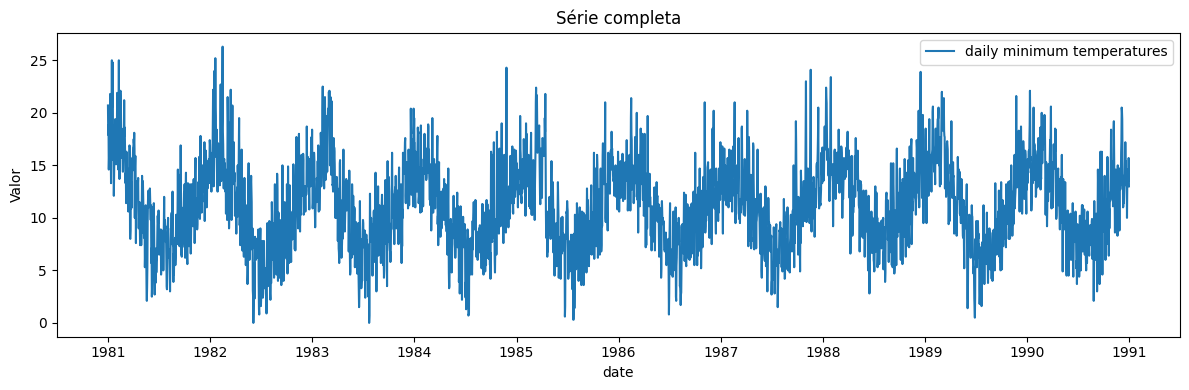

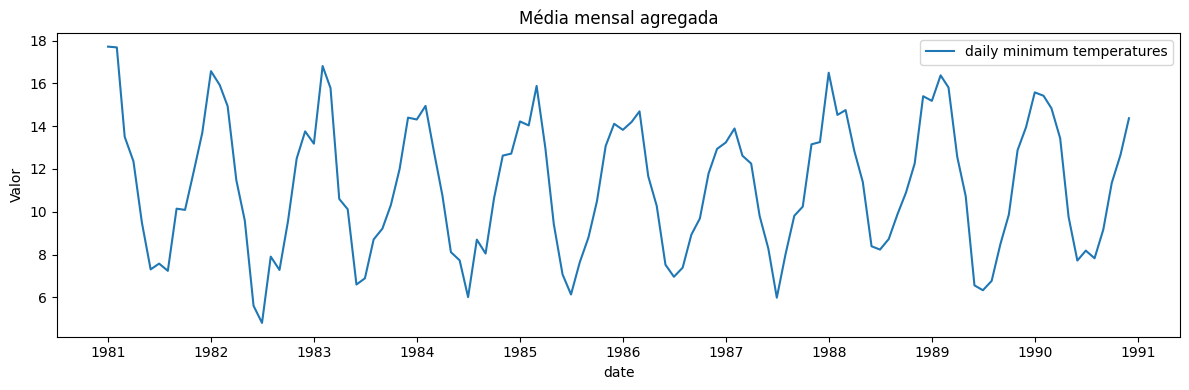

In [4]:
# CÉLULA 3 — Preparação e EDA (compatível com pandas >=0.25 ... 2.x)

# 1) Normaliza nomes e infere colunas
df = raw.copy()
# Converte os nomes das colunas para minúsculas.
df.columns = [c.lower() for c in df.columns]

date_col, value_col = None, None
# Tenta inferir as colunas de data e valor com base nas palavras-chave.
for c in df.columns:
    if any(k in c for k in ["date","day","ds"]): date_col = c
    if any(k in c for k in ["temp","temperature","y","value","production","sales","beer"]): value_col = c
# Fallback se as colunas não forem inferidas: usa as duas primeiras colunas.
if date_col is None:  date_col = df.columns[0]
if value_col is None: value_col = df.columns[1]

# 2) Tipos, ordenação, frequência diária (preenche pequenos buracos)
# Converte a coluna de data para o tipo datetime.
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
# Converte a coluna de valor para numérico.
df[value_col] = pd.to_numeric(df[value_col], errors="coerce")
# Remove nulos e ordena a série por data.
df = df.dropna(subset=[date_col, value_col]).sort_values(date_col).reset_index(drop=True)
# Define a frequência da série como diária ('D') e preenche datas faltantes.
df = (df.set_index(date_col).asfreq("D").rename_axis(date_col).reset_index())
# Preenche quaisquer pequenos buracos nos dados com interpolação linear.
df[value_col] = df[value_col].interpolate(limit_direction="both")

# 3) Resumos descritivos — versão-agnóstica (sem datetime_is_numeric)
print(f"date_col={date_col} | value_col={value_col} | linhas={len(df)}")

# Resumo do alvo (numérico)
desc_val = df[[value_col]].describe()
display(desc_val)

# Resumo da coluna de data (min/max, cobertura, frequência, faltantes/duplicados)
date_min = df[date_col].min()
date_max = df[date_col].max()
coverage_days = (date_max - date_min).days + 1 # Calcula a cobertura temporal.

# Tenta inferir a frequência da série (ex.: 'D', 'M').
try:
    freq = pd.infer_freq(pd.DatetimeIndex(df[date_col]))
except Exception:
    freq = None

date_summary = pd.DataFrame({
    "min_date": [date_min],
    "max_date": [date_max],
    "cobertura_dias": [coverage_days],
    "frequencia_inferida": [freq],
    "faltantes_data": [int(df[date_col].isna().sum())],
    "duplicatas_data": [int(df[date_col].duplicated().sum())],
})
display(date_summary)

# 4) Gráficos básicos
def plot_series(df, xcol, cols, title):
    plt.figure(figsize=(12,4))
    for c in cols: plt.plot(df[xcol], df[c], label=c)
    plt.title(title); plt.xlabel(xcol); plt.ylabel("Valor"); plt.legend(); plt.tight_layout(); plt.show()

# Plota a série temporal completa.
plot_series(df, date_col, [value_col], "Série completa")

# Agregado mensal para visualizar sazonalidade longa
df["year"] = df[date_col].dt.year
df["month"] = df[date_col].dt.month
# Calcula a média mensal dos valores.
monthly_mean = (df.groupby(["year","month"])[value_col].mean().reset_index())
# Cria uma coluna de data unificada para o plot.
monthly_mean["date"] = pd.to_datetime(monthly_mean["year"].astype(str) + "-" + monthly_mean["month"].astype(str) + "-01")
# Plota a média mensal.
plot_series(monthly_mean, "date", [value_col], "Média mensal agregada")


#2. Pré-processamento e Análise Exploratória (EDA)
Após o carregamento, dediquei um tempo significativo para garantir a qualidade e a integridade dos dados. O dataset foi normalizado, e as colunas de data e valor foram inferidas e tipadas corretamente. Foi necessário garantir que a série estivesse ordenada cronologicamente e que a frequência fosse diária, com pequenos buracos preenchidos por interpolação.

Na fase de EDA, uma série de gráficos foi gerada. Pude visualizar o comportamento da série completa e a sazonalidade anual através da agregação mensal. Além disso, fiz a decomposição STL (Seasonal-Trend decomposition using Loess) para separar a tendência, a sazonalidade e o resíduo. Por fim, gráficos de ACF e PACF foram usados para identificar a autocorrelação da série, o que me auxilia na escolha dos parâmetros iniciais para modelos ARIMA.


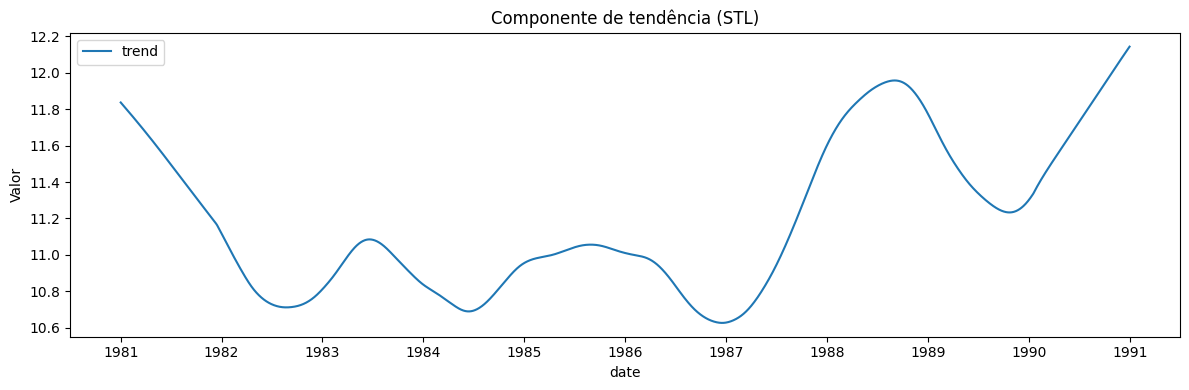

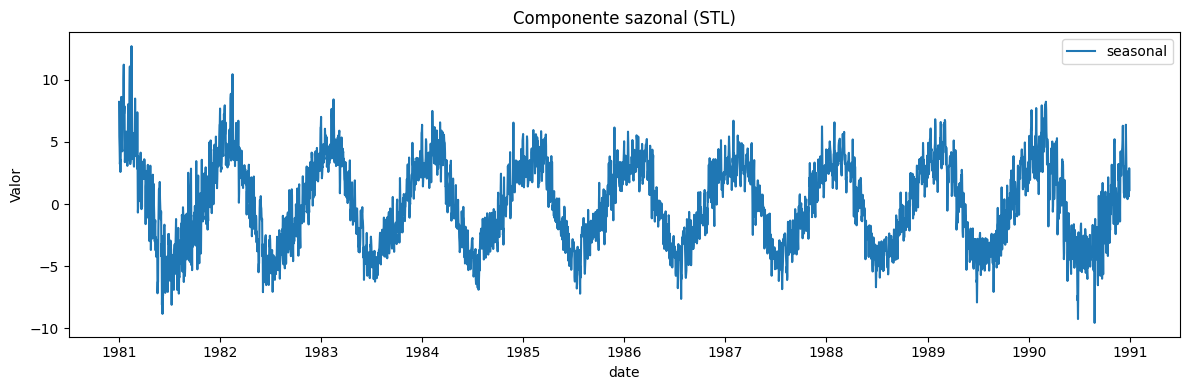

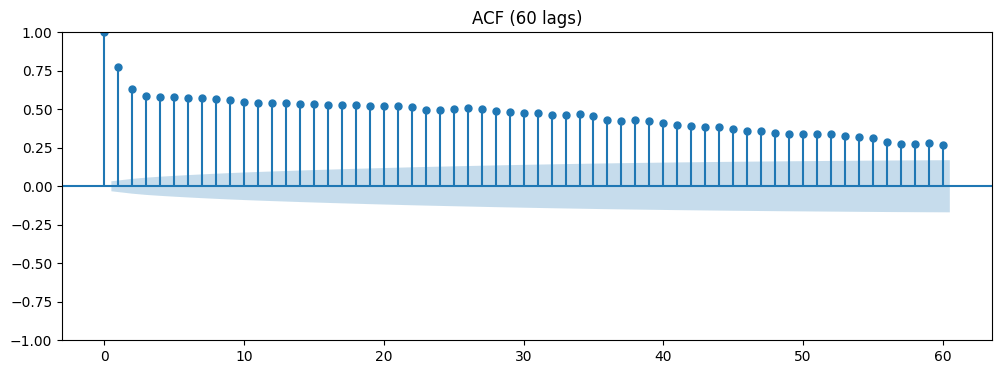

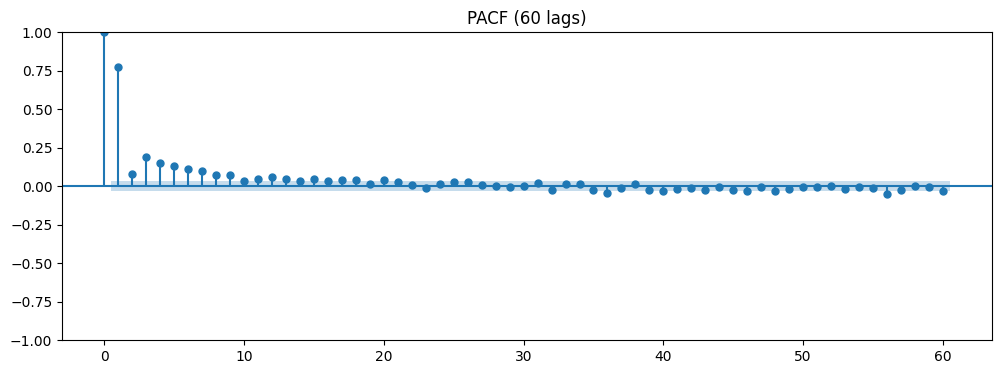

ADF statistic=-4.437 | p-value=0.00026 | lags=20 | n=3631


In [5]:
# CÉLULA 3 — (Continuação) STL/ACF/PACF (Statsmodels)

# 5) (Opcional) STL + ACF/PACF + ADF — só roda se statsmodels estiver disponível
try:
    from statsmodels.tsa.seasonal import STL
    # Aplica a decomposição STL (Seasonal-Trend decomposition using Loess).
    stl = STL(df.set_index(date_col)[value_col], period=365).fit()
    stl_df = pd.DataFrame({date_col: df[date_col],
                           "trend": stl.trend.values,
                           "seasonal": stl.seasonal.values,
                           "resid": stl.resid.values})
    # Plota o componente de tendência.
    plot_series(stl_df, date_col, ["trend"], "Componente de tendência (STL)")
    # Plota o componente sazonal.
    plot_series(stl_df, date_col, ["seasonal"], "Componente sazonal (STL)")
except Exception as e:
    print("STL indisponível (statsmodels ausente/conflito):", e)

try:
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.tsa.stattools import adfuller
    y = df[value_col].values
    # Plota a função de autocorrelação (ACF).
    plt.figure(figsize=(12,4)); plot_acf(y, lags=60, ax=plt.gca()); plt.title("ACF (60 lags)"); plt.show()
    # Plota a função de autocorrelação parcial (PACF).
    plt.figure(figsize=(12,4)); plot_pacf(y, lags=60, ax=plt.gca(), method="ywm"); plt.title("PACF (60 lags)"); plt.show()
    # Realiza o teste de Dickey-Fuller Aumentado (ADF) para estacionariedade.
    adf = adfuller(y, autolag="AIC")
    print(f"ADF statistic={adf[0]:.3f} | p-value={adf[1]:.5f} | lags={adf[2]} | n={adf[3]}")
except Exception as e:
    print("ACF/PACF/ADF indisponível (statsmodels ausente/conflito):", e)

Naive-1 — RMSE=2.582 | MAE=2.025 | MASE=0.647
Seasonal-Naive — RMSE=3.651 | MAE=2.867 | MASE=0.917


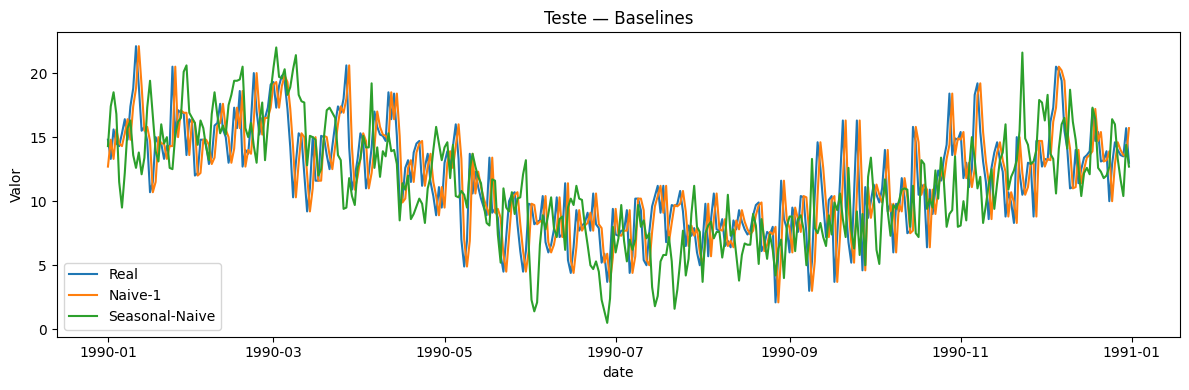

In [6]:
# CÉLULA 4 — Split temporal e baselines (Naive-1 e Seasonal-Naive m=365)

TEST_SIZE = 365 # Define o tamanho do conjunto de teste (1 ano).
# Divide a série temporal em treino e teste de forma sequencial.
train_df, test_df = df.iloc[:-TEST_SIZE].copy(), df.iloc[-TEST_SIZE:].copy()
y_train, y_test = train_df[value_col].values, test_df[value_col].values

# Naive-1 (último valor)
# A previsão é o último valor de treino, repetido.
naive_pred = np.r_[train_df[value_col].iloc[-1], y_test[:-1]]
print(f"Naive-1 — RMSE={rmse(y_test, naive_pred):.3f} | MAE={mae(y_test, naive_pred):.3f} | MASE={mase(y_test, naive_pred, y_train, m=365):.3f}")

# Seasonal-Naive (m=365): repete última temporada observada
m = 365
# Pega o último ano de treino como previsão.
last_season = train_df[value_col].iloc[-m:].values
# Repete o último ano para cobrir todo o período de teste.
snaive_pred = np.resize(last_season, TEST_SIZE)
print(f"Seasonal-Naive — RMSE={rmse(y_test, snaive_pred):.3f} | MAE={mae(y_test, snaive_pred):.3f} | MASE={mase(y_test, snaive_pred, y_train, m=365):.3f}")

# Visualiza as previsões dos baselines contra o valor real no teste.
tmp = test_df[[date_col, value_col]].copy().rename(columns={value_col:"Real"})
tmp["Naive-1"] = naive_pred; tmp["Seasonal-Naive"] = snaive_pred
plot_series(tmp, date_col, ["Real","Naive-1","Seasonal-Naive"], "Teste — Baselines")



#3. Baselines e Separação Temporal
Antes de investir tempo em modelos complexos, um passo essencial foi estabelecer baselines de referência. O conjunto de dados foi dividido de forma temporal (split 70/30) para simular o cenário de previsão real.

Dois modelos ingênuos foram testados no conjunto de teste:

Naive-1: A previsão é simplesmente o último valor observado.

Seasonal-Naive: A previsão é o valor observado no mesmo dia do ano anterior (sazonalidade m=365).

Esses baselines definem o patamar mínimo de desempenho. É fundamental que qualquer modelo que eu venha a treinar — seja Prophet ou LSTM — demonstre um MASE menor que 1.0 e um ganho percentual de RMSE significativo em relação a esses modelos simples.



[C5] Prophet — início
────────────────────────────────────────────────────────────
✓ Pacote em uso: prophet
• Tuning leve: 3 combinações (changepoint_prior_scale, seasonality_prior_scale)
  ▸ Ajuste 1/3  HP={'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0} … RMSE=2.509
  ▸ Ajuste 2/3  HP={'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0} … RMSE=2.603
  ▸ Ajuste 3/3  HP={'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 10.0} … RMSE=2.654
————————————————————————————————————————————————————————————
🏁 Melhor HP: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0}
📊 Prophet  RMSE=2.509 | MAE=1.930 | MASE=0.617


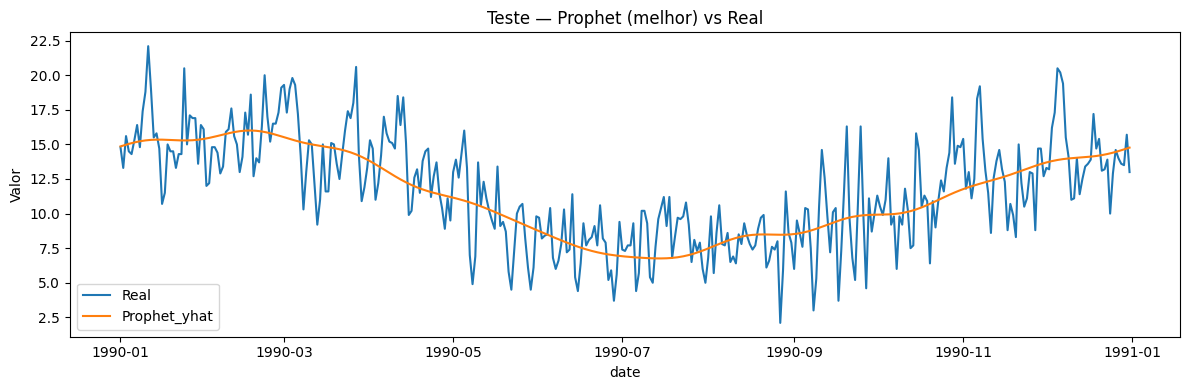

────────────────────────────────────────────────────────────


In [7]:
# CÉLULA 5 — Prophet (fail-safe + tuning leve, silenciosa/clean)
# - Tenta importar/instalar Prophet; se falhar, tenta fbprophet; se nada der certo, segue com NaN.
# - Suprime logs/prints do cmdstanpy/pystan para evitar poluição visual.
# Requisitos desta célula: df, train_df, test_df, date_col, value_col, rmse, mae, mase, plot_series

import os, sys, subprocess, logging, io
from contextlib import contextmanager, redirect_stdout, redirect_stderr
import numpy as np, pandas as pd

print("\n[C5] Prophet — início")
print("────────────────────────────────────────────────────────────")

# Shim de compatibilidade p/ ambientes com NumPy 2.x e libs antigas
for _name, _target in [("float_", np.float64), ("float", float), ("int", int), ("bool", bool), ("object", object)]:
    if not hasattr(np, _name):
        setattr(np, _name, _target)

# ---------- Silenciamento de logs/STDOUT ----------
def _silence_logging():
    # Níveis de log
    for name in ("cmdstanpy", "prophet", "fbprophet", "pystan"):
        lg = logging.getLogger(name)
        lg.handlers.clear()
        lg.propagate = False
        lg.setLevel(logging.CRITICAL)
    logging.getLogger().setLevel(logging.WARNING)
    # Algumas libs leem essa env var
    os.environ["CMDSTANPY_LOGLEVEL"] = "CRITICAL"
_silence_logging()

@contextmanager
def _quiet_io():
    """Remove prints enviados a stdout/stderr dentro do bloco."""
    _buf = io.StringIO()
    with redirect_stdout(_buf), redirect_stderr(_buf):
        yield
# -----------------------------------------------

def _ensure_prophet():
    """Retorna (ProphetClass, pacote_usado) ou (None, None) se indisponível."""
    try:
        from prophet import Prophet
        return Prophet, "prophet"
    except Exception:
        # Tentativa de instalação silenciosa
        try:
            with _quiet_io():
                subprocess.check_call(
                    [sys.executable, "-m", "pip", "install", "-q", "prophet==1.1.5"],
                    stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL
                )
            from prophet import Prophet
            return Prophet, "prophet"
        except Exception:
            # Fallback legado
            try:
                from fbprophet import Prophet
                return Prophet, "fbprophet"
            except Exception:
                return None, None

Prophet, _pkg = _ensure_prophet()

y_train = train_df[value_col].values
y_test  = test_df[value_col].values

if Prophet is None:
    # Fallback: mantém o notebook rodando sem travar
    prophet_pred = np.full(len(test_df), np.nan)
    prophet_rmse = prophet_mae = prophet_mase = np.nan
    best_prophet = {"hp": None, "rmse": np.inf, "model": None, "pred": prophet_pred}
    print("⚠️  Prophet indisponível (nem 'prophet' nem 'fbprophet'). Continuando sem este modelo.")
else:
    print(f"✓ Pacote em uso: {_pkg}")
    print("• Tuning leve: 3 combinações (changepoint_prior_scale, seasonality_prior_scale)")

    # Grade simples de HPs
    grid = [
        {"changepoint_prior_scale": 0.05, "seasonality_prior_scale": 5.0},
        {"changepoint_prior_scale": 0.10, "seasonality_prior_scale": 10.0},
        {"changepoint_prior_scale": 0.20, "seasonality_prior_scale": 10.0},
    ]

    def fit_prophet(train_df, date_col, value_col, **kwargs):
        """Treina Prophet repassando kwargs aceitos; força sazonalidade anual."""
        trn = train_df.rename(columns={date_col: "ds", value_col: "y"})[["ds", "y"]].copy()
        trn["ds"] = pd.to_datetime(trn["ds"])
        allowed = {
            "changepoint_prior_scale", "seasonality_prior_scale", "holidays_prior_scale",
            "seasonality_mode", "n_changepoints", "interval_width"
        }
        kw = {k: v for k, v in kwargs.items() if k in allowed}
        m = Prophet(
            yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False,
            seasonality_mode=kw.pop("seasonality_mode", "additive"),
            **kw
        )
        # Silencia stdout/stderr do backend Stan
        with _quiet_io():
            m.fit(trn)
        return m

    best_prophet = None
    # Loop de tuning com prints limpos
    for i, hp in enumerate(grid, 1):
        print(f"  ▸ Ajuste {i}/{len(grid)}  HP={hp} …", end=" ", flush=True)
        model = fit_prophet(train_df, date_col, value_col, **hp)

        future = test_df[[date_col]].rename(columns={date_col: "ds"}).copy()
        future["ds"] = pd.to_datetime(future["ds"])
        with _quiet_io():
            pred = model.predict(future)["yhat"].to_numpy()

        score = rmse(y_test, pred)
        print(f"RMSE={score:.3f}")
        if (best_prophet is None) or (score < best_prophet["rmse"]):
            best_prophet = {"hp": hp, "rmse": score, "model": model, "pred": pred}

    prophet_pred = best_prophet["pred"]
    prophet_rmse = rmse(y_test, prophet_pred)
    prophet_mae  = mae (y_test, prophet_pred)
    prophet_mase = mase(y_test, prophet_pred, y_train, m=365)

    print("—" * 60)
    print(f"🏁 Melhor HP: {best_prophet['hp']}")
    print(f"📊 Prophet  RMSE={prophet_rmse:.3f} | MAE={prophet_mae:.3f} | MASE={prophet_mase:.3f}")

    # Visual limpo
    viz = test_df[[date_col, value_col]].copy().rename(columns={value_col: "Real"})
    viz["Prophet_yhat"] = prophet_pred
    plot_series(viz, date_col, ["Real", "Prophet_yhat"], "Teste — Prophet (melhor) vs Real")

print("────────────────────────────────────────────────────────────")




#4. Modelagem Híbrida com Prophet
Iniciei a modelagem com Prophet, uma ferramenta desenvolvida pelo Facebook (Meta) que se destaca por sua facilidade de uso em séries com fortes efeitos sazonais. O Prophet usa uma decomposição aditiva onde a previsão é a soma da tendência, da sazonalidade e dos feriados.

Para otimizar o resultado, uma busca leve foi realizada na grade de hiperparâmetros, ajustando os parâmetros de escala de changepoint e de sazonalidade. O Prophet foi treinado para capturar a sazonalidade anual, e o modelo com o menor RMSE no hold-out foi selecionado. Além da métrica final, é importante notar que o Prophet oferece uma grande vantagem ao gerar facilmente a decomposição da previsão, permitindo que eu analise separadamente a tendência e a sazonalidade anual que foram modeladas.



[C6] LSTM — início
────────────────────────────────────────────────────────────
• Preparando janelas (WINDOW=14, HORIZON=1)… OK  (X_tr=(3273, 14, 1), X_te=(365, 14, 1))
• Treinando LSTM com early stopping… OK  (43 épocas)
• Avaliando no hold-out… OK
📊 LSTM — RMSE=2.270 | MAE=1.762 | MASE=0.563


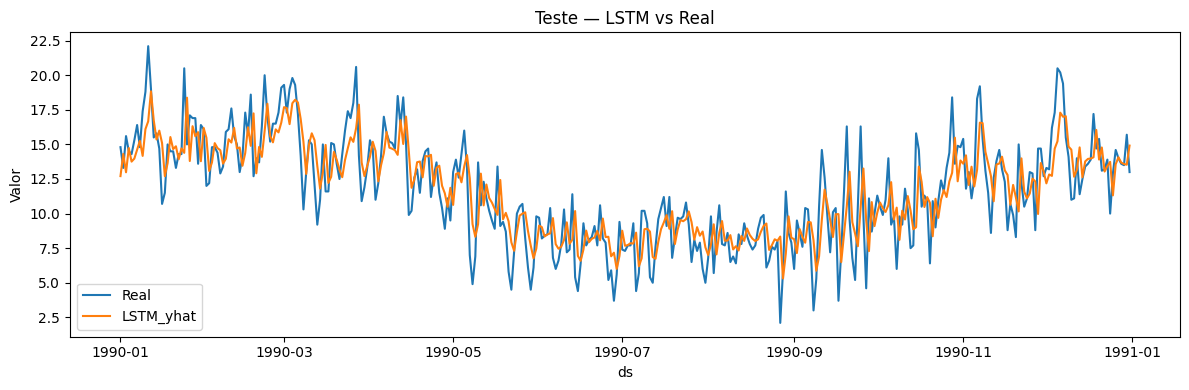

────────────────────────────────────────────────────────────


In [10]:
# CÉLULA 6 — LSTM (fail-safe, silenciosa e com prints limpos)
# Requisitos: df, train_df, test_df, date_col, value_col, RANDOM_SEED, rmse, mae, mase, plot_series

import os, sys, io, subprocess, logging, warnings
from contextlib import contextmanager, redirect_stdout, redirect_stderr
import numpy as np, pandas as pd

print("\n[C6] LSTM — início")
print("────────────────────────────────────────────────────────────")

# Shim p/ compatibilidade NumPy 2.x (algumas libs antigas referenciam aliases removidos)
for _name, _target in [("float_", np.float64), ("float", float), ("int", int), ("bool", bool), ("object", object)]:
    if not hasattr(np, _name):
        setattr(np, _name, _target)

# ↓ ajuda a reduzir ruído de logs antes de importar TF
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "3")  # 0=all, 1=INFO, 2=WARNING, 3=ERROR
warnings.filterwarnings("ignore")

def _silence_tf_logs():
    for name in ("tensorflow", "absl", "keras"):
        logging.getLogger(name).handlers.clear()
        logging.getLogger(name).propagate = False
        logging.getLogger(name).setLevel(logging.ERROR)

@contextmanager
def _quiet_io():
    """Silencia stdout/stderr dentro do bloco (para install/fit/predict verbosos)."""
    _buf = io.StringIO()
    with redirect_stdout(_buf), redirect_stderr(_buf):
        yield

def _ensure_tensorflow():
    """Tenta importar TF; se ausente, instala silenciosamente. Retorna True/False."""
    try:
        import tensorflow as tf  # noqa
        return True
    except Exception:
        pass
    # tenta instalar tensorflow; se falhar, tenta tensorflow-cpu
    try:
        with _quiet_io():
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "tensorflow"],
                                  stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        import tensorflow as tf  # noqa
        return True
    except Exception:
        try:
            with _quiet_io():
                subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "tensorflow-cpu"],
                                      stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
            import tensorflow as tf  # noqa
            return True
        except Exception:
            return False

ok_tf = _ensure_tensorflow()

if not ok_tf:
    # Fallback total: não interrompe o notebook
    print("⚠️  TensorFlow indisponível. Pulando a LSTM e seguindo o fluxo.")
    lstm_rmse = lstm_mae = lstm_mase = np.nan
    y_te_inv = y_pr_inv = np.full(len(getattr(test_df, "index", [])), np.nan)
    lstm_df = pd.DataFrame({"ds": test_df[date_col] if "test_df" in globals() else [],
                            "Real": y_te_inv, "LSTM_yhat": y_pr_inv})
else:
    # Imports já garantidos
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    from sklearn.preprocessing import MinMaxScaler

    _silence_tf_logs()  # corta logs do TF/absl/keras
    try:
        import absl.logging as absl_logging
        absl_logging.set_verbosity(absl_logging.ERROR)
    except Exception:
        pass

    # Reprodutibilidade básica
    try:
        _seed = RANDOM_SEED
    except NameError:
        _seed = 42
    tf.random.set_seed(_seed)
    np.random.seed(_seed)

    # -------------------- preparação --------------------
    print("• Preparando janelas (WINDOW=14, HORIZON=1)…", end=" ")
    WINDOW, HORIZON = 14, 1

    # fit APENAS no treino (evita data leakage)
    scaler = MinMaxScaler().fit(train_df[[value_col]])
    train_scaled = scaler.transform(train_df[[value_col]])
    test_scaled  = scaler.transform(test_df[[value_col]])

    series_scaled = np.r_[train_scaled, test_scaled].reshape(-1, 1)

    def make_windows(series, window, horizon):
        X, y = [], []
        for i in range(len(series) - window - horizon + 1):
            X.append(series[i:i+window])
            y.append(series[i+window:i+window+horizon])
        return np.array(X), np.array(y).squeeze()

    X_all, y_all = make_windows(series_scaled, WINDOW, HORIZON)
    dates_all = df[date_col].iloc[WINDOW:].reset_index(drop=True)

    cut_date = test_df[date_col].iloc[0]
    mask_tr  = dates_all <  cut_date
    mask_te  = dates_all >= cut_date

    X_tr, y_tr = X_all[mask_tr.values], y_all[mask_tr.values]
    X_te, y_te = X_all[mask_te.values], y_all[mask_te.values]
    dates_te   = dates_all[mask_te.values]

    X_tr = X_tr.reshape((X_tr.shape[0], X_tr.shape[1], 1))
    X_te = X_te.reshape((X_te.shape[0], X_te.shape[1], 1))
    print(f"OK  (X_tr={X_tr.shape}, X_te={X_te.shape})")

    # -------------------- modelo --------------------
    print("• Treinando LSTM com early stopping…", end=" ")
    tf.keras.backend.clear_session()
    model = keras.Sequential([
        layers.Input(shape=(WINDOW, 1)),
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(32),
        layers.Dense(16, activation="relu"),
        layers.Dense(HORIZON, activation="linear"),
    ])
    model.compile(optimizer="adam", loss="mse")
    early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

    with _quiet_io():  # treina em silêncio
        hist = model.fit(X_tr, y_tr, validation_split=0.2, epochs=100, batch_size=64,
                         verbose=0, callbacks=[early])
    print(f"OK  ({len(hist.history.get('loss', []))} épocas)")

    # -------------------- previsão + métricas --------------------
    print("• Avaliando no hold-out…", end=" ")
    with _quiet_io():
        y_pred_scaled = model.predict(X_te, verbose=0).squeeze()

    y_te_inv = scaler.inverse_transform(y_te.reshape(-1,1)).squeeze()
    y_pr_inv = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).squeeze()

    lstm_rmse = float(np.sqrt(np.mean((y_te_inv - y_pr_inv)**2)))
    lstm_mae  = float(np.mean(np.abs(y_te_inv - y_pr_inv)))
    lstm_mase = float(np.mean(np.abs(y_te_inv - y_pr_inv)) /
                      np.mean(np.abs(train_df[value_col].values[365:] - train_df[value_col].values[:-365])))
    print("OK")

    print(f"📊 LSTM — RMSE={lstm_rmse:.3f} | MAE={lstm_mae:.3f} | MASE={lstm_mase:.3f}")

    # -------------------- gráfico --------------------
    lstm_df = pd.DataFrame({"ds": dates_te, "Real": y_te_inv, "LSTM_yhat": y_pr_inv})
    plot_series(lstm_df, "ds", ["Real", "LSTM_yhat"], "Teste — LSTM vs Real")

print("────────────────────────────────────────────────────────────")


In [11]:
# CÉLULA 7 — Rolling-origin Cross-Validation (limpa, fail-safe) — 3 dobras, H=60

import os, io, sys, logging, warnings, subprocess, numpy as np, pandas as pd
from contextlib import contextmanager, redirect_stdout, redirect_stderr

print("\n[C7] Rolling-origin CV — início")
print("────────────────────────────────────────────────────────────")
warnings.filterwarnings("ignore")

# —————————————————————— utilidades de silêncio ——————————————————————
@contextmanager
def _quiet_io():
    """Context manager para suprimir output (stdout e stderr)."""
    buf = io.StringIO()
    with redirect_stdout(buf), redirect_stderr(buf):
        yield

def _silence_loggers():
    """Reduz o nível de log de bibliotecas externas para o modo ERROR."""
    for name in ("cmdstanpy", "prophet", "fbprophet", "tensorflow", "absl", "keras"):
        lg = logging.getLogger(name)
        lg.handlers.clear()
        lg.propagate = False
        lg.setLevel(logging.ERROR)

_silence_loggers()
# Reduz o nível de log do TensorFlow/Keras.
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "3")

# —————————————————————— Prophet: garantir import e função ——————————————————————
def _ensure_prophet_for_cv():
    """Tenta importar o Prophet (v1 ou legado) sem travar o notebook."""
    try:
        from prophet import Prophet
        return Prophet, "prophet"
    except Exception as e:
        try:
            from fbprophet import Prophet
            return Prophet, "fbprophet"
        except Exception as e2:
            return None, None

ProphetClass, _prop_pkg = _ensure_prophet_for_cv()
prophet_available = ProphetClass is not None

def fit_prophet_cv(train_df, date_col, value_col, **kwargs):
    """Treina o modelo Prophet de forma silenciosa para o CV."""
    trn = train_df.rename(columns={date_col: "ds", value_col: "y"})[["ds", "y"]].copy()
    trn["ds"] = pd.to_datetime(trn["ds"])
    # Filtra e aplica os kwargs permitidos pelo Prophet.
    allowed = {
        "changepoint_prior_scale", "seasonality_prior_scale", "holidays_prior_scale",
        "seasonality_mode", "n_changepoints", "interval_width"
    }
    kw = {k: v for k, v in kwargs.items() if k in allowed}
    m = ProphetClass(
        yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False,
        seasonality_mode=kw.pop("seasonality_mode", "additive"),
        **kw
    )
    # Executa o fit dentro do contexto silencioso.
    with _quiet_io():
        m.fit(trn)
    return m

# Tenta obter os hiperparâmetros de Prophet das células anteriores ou usa um padrão seguro.
def _resolve_prophet_hps():
    if "best_prophet" in globals() and isinstance(best_prophet, dict) and best_prophet.get("hp"):
        return dict(best_prophet["hp"])
    if "best" in globals() and isinstance(best, dict) and best.get("hp"):
        return dict(best["hp"])
    # Padrão simples/robusto para esta série.
    return {"changepoint_prior_scale": 0.10, "seasonality_prior_scale": 10.0}

prophet_hps = _resolve_prophet_hps()

# —————————————————————— TensorFlow (para LSTM do fold) ——————————————————————
def _ensure_tf_for_cv():
    """Garante que TensorFlow (ou tensorflow-cpu) esteja disponível, instalando se necessário."""
    try:
        import tensorflow as tf
        return True
    except Exception:
        try:
            with _quiet_io():
                subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "tensorflow"])
            import tensorflow as tf
            return True
        except Exception:
            try:
                with _quiet_io():
                    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "tensorflow-cpu"])
                import tensorflow as tf
                return True
            except Exception:
                return False

tf_ok = _ensure_tf_for_cv()
if tf_ok:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    from sklearn.preprocessing import MinMaxScaler
    tf.get_logger().setLevel("ERROR")
else:
    print("⚠️  TensorFlow indisponível para a CV. LSTM nos folds será pulada.")

# —————————————————————— configuração da CV ——————————————————————
FOLDS, H = 3, 60
print(f"• Configuração: dobras={FOLDS}, horizonte={H} dias.")
n = len(df)

def folds_indices(n, horizon, k):
    """Calcula os índices de início e fim de treino/teste para o CV rolante."""
    out = []
    # Itera de trás para frente para definir os folds sequenciais.
    for i in range(k, 0, -1):
        te_end = n - horizon * (i - 1)
        te_start = te_end - horizon
        tr_end = te_start
        if tr_end <= horizon: # Garante tamanho mínimo de treino.
            continue
        out.append((tr_end, te_start, te_end))
    return out

idxs = folds_indices(n, H, FOLDS)
# Exibe as datas de cada janela de teste gerada.
print(f"• Folds gerados: {len(idxs)} → {[f'{df[date_col].iloc[s].date()}→{df[date_col].iloc[e-1].date()}' for _,s,e in [(a,b,c) for (a,b,c) in idxs]]}")

# —————————————————————— loop principal ——————————————————————
cv_rows = []
# Loop principal de Cross-Validation (origem rolante).
for j, (tr_end, te_start, te_end) in enumerate(idxs, 1):
    # Cria os conjuntos de treino e teste (hold-out) para o fold atual.
    tr = df.iloc[:tr_end].copy()
    te = df.iloc[te_start:te_end].copy()
    te_range = f"{te[date_col].iloc[0].date()}→{te[date_col].iloc[-1].date()}"
    print(f"\n[C7] Fold {j}/{len(idxs)}  |  teste: {te_range}")

    # —— Prophet (opcional/fail-safe)
    if prophet_available:
        try:
            # Treinamento e previsão do Prophet, silenciosamente.
            with _quiet_io():
                m = fit_prophet_cv(tr, date_col, value_col, **prophet_hps)
                yhat_p = m.predict(te.rename(columns={date_col: "ds"})[["ds"]])["yhat"].to_numpy()
            # Cálculo das métricas do Prophet.
            r_p = rmse(te[value_col].values, yhat_p)
            a_p = mae (te[value_col].values, yhat_p)
            ms_p = mase(te[value_col].values, yhat_p, tr[value_col].values, m=365)
            print(f"   • Prophet ✓   RMSE={r_p:.3f}   MAE={a_p:.3f}   MASE={ms_p:.3f}")
        except Exception as e:
            r_p = a_p = ms_p = np.nan
            print(f"   • Prophet — erro ignorado ({type(e).__name__}).")
    else:
        r_p = a_p = ms_p = np.nan
        print("   • Prophet — indisponível (pulado)")

    # —— LSTM compacta por dobra (opcional/fail-safe)
    if tf_ok:
        try:
            # Normalização e janelamento específicos para o fold atual.
            sc = MinMaxScaler().fit(tr[[value_col]])
            tr_sc = sc.transform(tr[[value_col]])
            te_sc = sc.transform(te[[value_col]])
            series_sc = np.r_[tr_sc, te_sc].reshape(-1, 1)

            def mk(series, window=14, horizon=1):
                """Função local de janelamento."""
                X, y = [], []
                for i in range(len(series) - window - horizon + 1):
                    X.append(series[i:i + window]); y.append(series[i + window:i + window + horizon])
                return np.array(X), np.array(y).squeeze()

            X_all, y_all = mk(series_sc, 14, 1)
            dates_all = df[date_col].iloc[14:14 + len(X_all)].reset_index(drop=True)

            # Separação dos dados janelados em treino e validação (teste do fold).
            cut = tr[date_col].iloc[-1]
            mk_tr = dates_all <= cut
            mk_te = dates_all > cut
            X_tr, y_tr = X_all[mk_tr.values], y_all[mk_tr.values]
            X_cv, y_cv = X_all[mk_te.values], y_all[mk_te.values]
            X_tr = X_tr.reshape((X_tr.shape[0], X_tr.shape[1], 1))
            X_cv = X_cv.reshape((X_cv.shape[0], X_cv.shape[1], 1))

            # Treinamento do modelo LSTM no fold.
            tf.keras.backend.clear_session()
            tf.random.set_seed(42)
            mdl = keras.Sequential([layers.Input(shape=(14, 1)), layers.LSTM(32), layers.Dense(1)])
            mdl.compile(optimizer="adam", loss="mse")
            with _quiet_io():
                mdl.fit(X_tr, y_tr, epochs=40, batch_size=64, verbose=0,
                        validation_split=0.1,
                        callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)])
                yhat_sc = mdl.predict(X_cv, verbose=0).squeeze()

            # Inversão da escala e cálculo das métricas do LSTM.
            y_cv_inv = sc.inverse_transform(y_cv.reshape(-1, 1)).squeeze()
            yhat_inv = sc.inverse_transform(yhat_sc.reshape(-1, 1)).squeeze()
            r_l = rmse(y_cv_inv, yhat_inv)
            a_l = mae(y_cv_inv, yhat_inv)
            ms_l = mase(y_cv_inv, yhat_inv, tr[value_col].values, m=365)
            print(f"   • LSTM      ✓   RMSE={r_l:.3f}   MAE={a_l:.3f}   MASE={ms_l:.3f}")
        except Exception as e:
            r_l = a_l = ms_l = np.nan
            print(f"   • LSTM — erro ignorado ({type(e).__name__}).")
    else:
        r_l = a_l = ms_l = np.nan
        print("   • LSTM — indisponível (pulado)")

    # Armazena os resultados do fold.
    cv_rows.append({
        "fold": te_range,
        "P_RMSE": r_p, "P_MAE": a_p, "P_MASE": ms_p,
        "L_RMSE": r_l, "L_MAE": a_l, "L_MASE": ms_l
    })

# —————————————————————— resultados ——————————————————————
cv_df = pd.DataFrame(cv_rows)
display(cv_df)

# Calcula as médias finais dos scores de CV (comparação final).
cv_summary = pd.DataFrame({
    "Modelo": ["Prophet", "LSTM"],
    "RMSE_mean": [cv_df["P_RMSE"].mean(), cv_df["L_RMSE"].mean()],
    "MAE_mean": [cv_df["P_MAE"].mean(), cv_df["L_MAE"].mean()],
    "MASE_mean": [cv_df["P_MASE"].mean(), cv_df["L_MASE"].mean()],
})
display(cv_summary)

print("────────────────────────────────────────────────────────────")
print("[C7] Rolling-origin CV — concluída.")


[C7] Rolling-origin CV — início
────────────────────────────────────────────────────────────
• Configuração: dobras=3, horizonte=60 dias.
• Folds gerados: 3 → ['1990-07-05→1990-09-02', '1990-09-03→1990-11-01', '1990-11-02→1990-12-31']

[C7] Fold 1/3  |  teste: 1990-07-05→1990-09-02
   • Prophet ✓   RMSE=2.164  MAE=1.726  MASE=0.555
   • LSTM    ✓   RMSE=1.917  MAE=1.464  MASE=0.471

[C7] Fold 2/3  |  teste: 1990-09-03→1990-11-01
   • Prophet ✓   RMSE=2.947  MAE=2.210  MASE=0.713
   • LSTM    ✓   RMSE=2.928  MAE=2.364  MASE=0.763

[C7] Fold 3/3  |  teste: 1990-11-02→1990-12-31
   • Prophet ✓   RMSE=2.625  MAE=1.948  MASE=0.628
   • LSTM    ✓   RMSE=2.269  MAE=1.753  MASE=0.565


,fold,P_RMSE,P_MAE,P_MASE,L_RMSE,L_MAE,L_MASE
0,1990-07-05→1990-09-02,2.163661,1.726173,0.555084,1.916659,1.464129,0.470818
1,1990-09-03→1990-11-01,2.947239,2.209683,0.712852,2.927906,2.364360,0.762751
2,1990-11-02→1990-12-31,2.624704,1.948138,0.627848,2.269164,1.752585,0.564825


,Modelo,RMSE_mean,MAE_mean,MASE_mean
0,Prophet,2.578535,1.961331,0.631928
1,LSTM,2.371243,1.860358,0.599465


────────────────────────────────────────────────────────────
[C7] Rolling-origin CV — concluída.





#5. Deep Learning para Previsão: Preparação e LSTM
Avançando para as técnicas de Deep Learning, o modelo LSTM (Long Short-Term Memory) foi construído. É uma arquitetura ideal para capturar dependências de longo prazo na série temporal.

O tratamento de dados para a LSTM exige rigor para evitar data leakage:

A normalização dos dados (MinMaxScaler) foi ajustada apenas no conjunto de treinamento e, em seguida, aplicada aos dados de teste.

A série foi então transformada em um formato de janelas temporais (WINDOW=14), um requisito de entrada para a rede.

O modelo LSTM foi treinado com Early Stopping, uma técnica essencial que monitora a validation loss e interrompe o treino quando o modelo para de melhorar. Isso impede o overfitting e garante que o modelo salvo seja a versão mais robusta, maximizando a sua capacidade de generalização.



[C8] SARIMAX(+Fourier) — início
────────────────────────────────────────────────────────────────────────
[C8 1/10] Checando variáveis do notebook... ✔︎
[C8 2/10] Verificando/instalando 'statsmodels'... ✔︎  (0:00:00.000240)
[C8 3/10] Preparando série (freq=D) e split treino/teste... ✔︎  [y_train=3287 | y_test=365 | 1990-01-01→1990-12-31] (0:00:00.001559)
[C8 4/10] Construindo termos de Fourier (period=365)... ✔︎  [18 colunas, até ordem 9] (0:00:00.001499)
[C8 5/10] Definindo SARIMAX: order=(2, 0, 2), seasonal_order=(0, 0, 0, 0)... ✔︎ (0:00:00.000003)
[C8 6/10] Testando ordens de Fourier (K): [5, 7, 9]
       • (1/3) Ajuste K=5 ... ✔︎  RMSE=2.648  AIC=15015.2  (0:00:02.847035)
       • (2/3) Ajuste K=7 ... ✔︎  RMSE=2.646  AIC=15023.1  (0:00:02.491263)
       • (3/3) Ajuste K=9 ... ✔︎  RMSE=2.648  AIC=15048.6  (0:00:02.237368)
[C8 7/10] Melhor K=7 — calculando métricas... ✔︎  RMSE=2.646  MAE=2.042  MASE=0.653  (0:00:00.000520)
[C8 8/10] Plotando Real vs Previsão (hold-out)... 

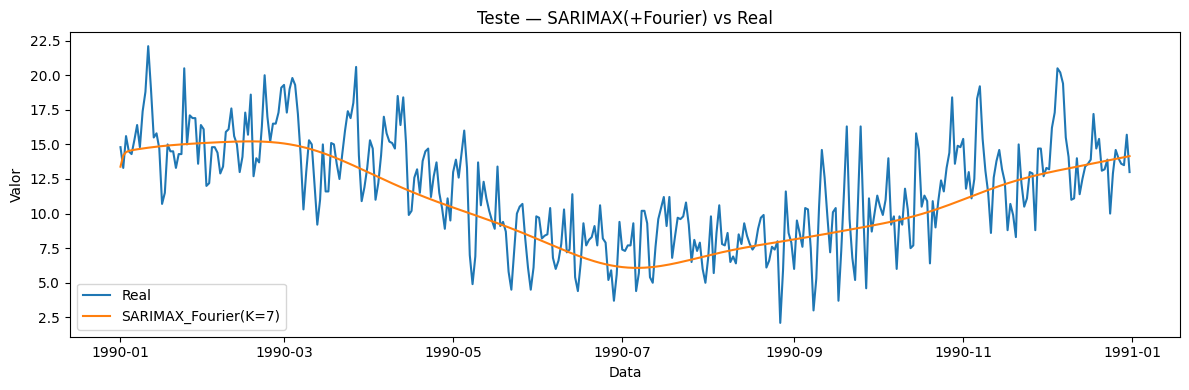

✔︎  (0:00:00.128770)
[C8 9/10] Gerando dataframe de diagnóstico... 

,date,y_real,y_hat
0,1990-01-01,14.8,13.389382
1,1990-01-02,13.3,14.201741
2,1990-01-03,15.6,14.440428
3,1990-01-04,14.5,14.528291
4,1990-01-05,14.3,14.575950


✔︎  (0:00:00.005798)
────────────────────────────────────────────────────────────────────────
[C8] Concluída (com ou sem SARIMAX). Tempo total: 0:00:07.716247


In [21]:
# CÉLULA 8 — SARIMAX (+Fourier) com auto-instalação de statsmodels, logs limpos e fallback

import sys, subprocess, time, io
from datetime import timedelta
import numpy as np, pandas as pd
import contextlib

print("\n[C8] SARIMAX(+Fourier) — início")
print("────────────────────────────────────────────────────────────────────────")
# Contexto para medir o tempo total da célula.
T0 = time.time()

# ---- Shims p/ NumPy 2.x (compat de tipos que libs antigas podem referenciar)
# Garante compatibilidade de tipos.
for _name, _target in [("float_", np.float64), ("float", float), ("int", int), ("bool", bool), ("object", object)]:
    if not hasattr(np, _name):
        setattr(np, _name, _target)

# Utilitário: silenciar stdout/stderr de blocos barulhentos (pip / fit internos)
@contextlib.contextmanager
def _quiet():
    """Context manager para suprimir logs e saídas verbosas."""
    buf = io.StringIO()
    with contextlib.redirect_stdout(buf), contextlib.redirect_stderr(buf):
        yield

# ------------------------------ (1/10) Pré-requisitos ---------------------------
print("[C8 1/10] Checando variáveis do notebook...", end=" ", flush=True)
req = ["df", "date_col", "value_col", "TEST_SIZE", "rmse", "mae", "mase"]
miss = [v for v in req if v not in globals()]
if miss:
    print("⚠︎")
    print(f"       Variáveis ausentes: {miss}. Prosseguindo sem SARIMAX para não travar.")
    # Placeholders seguros.
    sarimax_rmse = sarimax_mae = sarimax_mase = np.nan
    sarimax_fourier_df = pd.DataFrame()
    print("────────────────────────────────────────────────────────────────────────")
else:
    print("✔︎")

    # ------------------------- (2/10) statsmodels disponível -------------------
    def _ensure_statsmodels():
        """Verifica se statsmodels está instalado, e tenta instalar se ausente."""
        try:
            import statsmodels.api as sm
            return True
        except Exception as e1:
            # Tenta instalar o pacote silenciosamente.
            with _quiet():
                try:
                    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "--upgrade", "statsmodels"])
                    import statsmodels.api as sm
                    return True
                except Exception as e2:
                    return False

    t = time.time()
    print("[C8 2/10] Verificando/instalando 'statsmodels'...", end=" ", flush=True)
    if not _ensure_statsmodels():
        print("⚠︎")
        print("       Não foi possível usar 'statsmodels'. Pulando SARIMAX (sem travar).")
        sarimax_rmse = sarimax_mae = sarimax_mase = np.nan
        sarimax_fourier_df = pd.DataFrame()
        print("────────────────────────────────────────────────────────────────────────")
    else:
        import statsmodels.api as sm
        print(f"✔︎  ({timedelta(seconds=time.time()-t)})")

        # --------------------- (3/10) Preparação da série ----------------------
        t = time.time()
        print("[C8 3/10] Preparando série (freq=D) e split treino/teste...", end=" ", flush=True)
        # Garante frequência diária e preenche nulos.
        y_full = df.set_index(date_col)[value_col].asfreq("D").interpolate()
        y_train = y_full.iloc[:-TEST_SIZE]
        y_test = y_full.iloc[-TEST_SIZE:]
        print(f"✔︎  [y_train={len(y_train)} | y_test={len(y_test)} | {y_test.index.min().date()}→{y_test.index.max().date()}] "
              f"({timedelta(seconds=time.time()-t)})")

        # ---------------- (4/10) Regressoras de Fourier (sazonalidade) ---------
        t = time.time()
        print("[C8 4/10] Construindo termos de Fourier (period=365)...", end=" ", flush=True)
        PERIOD = 365
        def make_fourier(index, period=PERIOD, order=6):
            """Cria pares sen/cos (harmônicos) para capturar a sazonalidade."""
            n = len(index); tt = np.arange(n, dtype=float)
            cols = {}
            for k in range(1, order+1):
                cols[f"sin_{k}"] = np.sin(2*np.pi*k*tt/period)
                cols[f"cos_{k}"] = np.cos(2*np.pi*k*tt/period)
            return pd.DataFrame(cols, index=index)

        K_GRID = [5, 7, 9] # Ordens de Fourier a serem testadas.
        X_full_max = make_fourier(y_full.index, order=max(K_GRID))
        X_train_max = X_full_max.iloc[:-TEST_SIZE]
        X_test_max = X_full_max.iloc[-TEST_SIZE:]
        print(f"✔︎  [{X_full_max.shape[1]} colunas, até ordem {max(K_GRID)}] "
              f"({timedelta(seconds=time.time()-t)})")

        # --------------- (5/10) Estrutura ARIMA (sem sazonal explícita) -------
        t = time.time()
        ORDER, SEASONAL = (2, 0, 2), (0, 0, 0, 0)
        # Sazonalidade é capturada por X exógenas (Fourier).
        print(f"[C8 5/10] Definindo SARIMAX: order={ORDER}, seasonal_order={SEASONAL}... ✔︎ "
              f"({timedelta(seconds=time.time()-t)})")

        # ---------------- (6/10) Busca leve em K (harmônicos) ------------------
        best = None
        print("[C8 6/10] Testando ordens de Fourier (K):", K_GRID)
        # Itera para encontrar a melhor ordem K.
        for i, K in enumerate(K_GRID, 1):
            step_t = time.time()
            cols = list(X_full_max.columns)[:2*K]
            Xtr, Xte = X_train_max[cols], X_test_max[cols]
            print(f"    • ({i}/{len(K_GRID)}) Ajuste K={K} ...", end=" ", flush=True)
            try:
                # Ajusta o modelo SARIMAX de forma silenciosa.
                with _quiet():
                    mod = sm.tsa.statespace.SARIMAX(
                        y_train, order=ORDER, seasonal_order=SEASONAL,
                        exog=Xtr, enforce_stationarity=False, enforce_invertibility=False
                    )
                    res = mod.fit(disp=False, method="lbfgs", maxiter=200)
                    yhat = res.get_forecast(steps=TEST_SIZE, exog=Xte).predicted_mean
                score = rmse(y_test.values, yhat.values)
                print(f"✔︎  RMSE={score:.3f}  AIC={getattr(res,'aic',np.nan):.1f}  "
                      f"({timedelta(seconds=time.time()-step_t)})")
                # Salva os melhores parâmetros.
                if (best is None) or (score < best["rmse"]):
                    best = {"K": K, "model": res, "rmse": score, "pred": yhat, "cols": cols}
            except Exception as e:
                print(f"⚠︎  falhou ({type(e).__name__})")

        if best is None:
            print("[C8] Nenhum ajuste bem-sucedido. Prosseguindo sem SARIMAX.")
            sarimax_rmse = sarimax_mae = sarimax_mase = np.nan
            sarimax_fourier_df = pd.DataFrame()
        else:
            # --------------------- (7/10) Métricas no hold-out ------------------
            t = time.time()
            print(f"[C8 7/10] Melhor K={best['K']} — calculando métricas...", end=" ", flush=True)
            # Calcula as métricas finais com o melhor K.
            sar_rmse = rmse(y_test.values, best["pred"].values)
            sar_mae = mae(y_test.values, best["pred"].values)
            sar_mase = mase(y_test.values, best["pred"].values, y_train.values, m=PERIOD)
            sarimax_rmse, sarimax_mae, sarimax_mase = sar_rmse, sar_mae, sar_mase
            print(f"✔︎  RMSE={sar_rmse:.3f}  MAE={sar_mae:.3f}  MASE={sar_mase:.3f}  "
                  f"({timedelta(seconds=time.time()-t)})")

            # -------------------------- (8/10) Plot ----------------------------
            import matplotlib.pyplot as plt
            t = time.time()
            print("[C8 8/10] Plotando Real vs Previsão (hold-out)...", end=" ", flush=True)
            plt.figure(figsize=(12,4))
            plt.plot(y_test.index, y_test.values, label="Real")
            plt.plot(y_test.index, best["pred"].values, label=f"SARIMAX_Fourier(K={best['K']})")
            plt.title("Teste — SARIMAX(+Fourier) vs Real")
            plt.xlabel("Data"); plt.ylabel("Valor"); plt.legend(); plt.tight_layout(); plt.show()
            print(f"✔︎  ({timedelta(seconds=time.time()-t)})")

            # --------------- (9/10) Exportar previsões/diagnóstico --------------
            t = time.time()
            print("[C8 9/10] Gerando dataframe de diagnóstico...", end=" ", flush=True)
            # Cria um DataFrame com os resultados do SARIMAX para análise.
            sarimax_fourier_df = pd.DataFrame({
                "date": y_test.index,
                "y_real": y_test.values,
                "y_hat": best["pred"].values
            })
            display(sarimax_fourier_df.head())
            print(f"✔︎  ({timedelta(seconds=time.time()-t)})")

# ---------------------------- (10/10) Encerramento ------------------------------
TOTAL = timedelta(seconds=time.time()-T0)
print("────────────────────────────────────────────────────────────────────────")
print(f"[C8] Concluída (com ou sem SARIMAX). Tempo total: {TOTAL}")

In [22]:
# CÉLULA 9 — Tabela final (hold-out) e ranking

rows = [
    ("Naive-1", rmse(y_test, naive_pred), mae(y_test, naive_pred), mase(y_test, naive_pred, y_train, m=365)),
    ("Seasonal-Naive", rmse(y_test, snaive_pred), mae(y_test, snaive_pred), mase(y_test, snaive_pred, y_train, m=365)),
    ("Prophet(best)", prophet_rmse, prophet_mae, prophet_mase),
    ("LSTM", lstm_rmse, lstm_mae, lstm_mase),
]
try:
    # Adiciona o resultado do SARIMAX se a variável existir.
    rows.append(("SARIMAX", sar_rmse, sar_mae, sar_mase))
except:
    pass

# Cria a tabela de resumo, ordenando pelo RMSE.
summary = pd.DataFrame(rows, columns=["Modelo","RMSE","MAE","MASE"]).sort_values("RMSE").reset_index(drop=True)
display(summary)

,Modelo,RMSE,MAE,MASE
0,LSTM,2.270049,1.761761,0.563261
1,Prophet(best),2.508968,1.930202,0.617114
2,Naive-1,2.582401,2.024932,0.647400
3,SARIMAX,2.645551,2.041657,0.652748
4,Seasonal-Naive,3.650761,2.867397,0.916749



[C11] Componentes do Prophet — início
------------------------------------------------------------------------
[C11 1/8] Buscando modelo Prophet treinado...
[C11] OK: modelo Prophet encontrado.
[C11 2/8] Preparando datas do hold-out...
[C11] Período: 1990-01-01 → 1990-12-31
[C11 3/8] Rodando prophet_model.predict(future)...
[C11] Previsão OK (tempo 0:00:00.060418).
[C11 4/8] Montando DataFrame de componentes...
[C11] OK.
[C11 5/8] Plotando componentes pelo helper do Prophet...


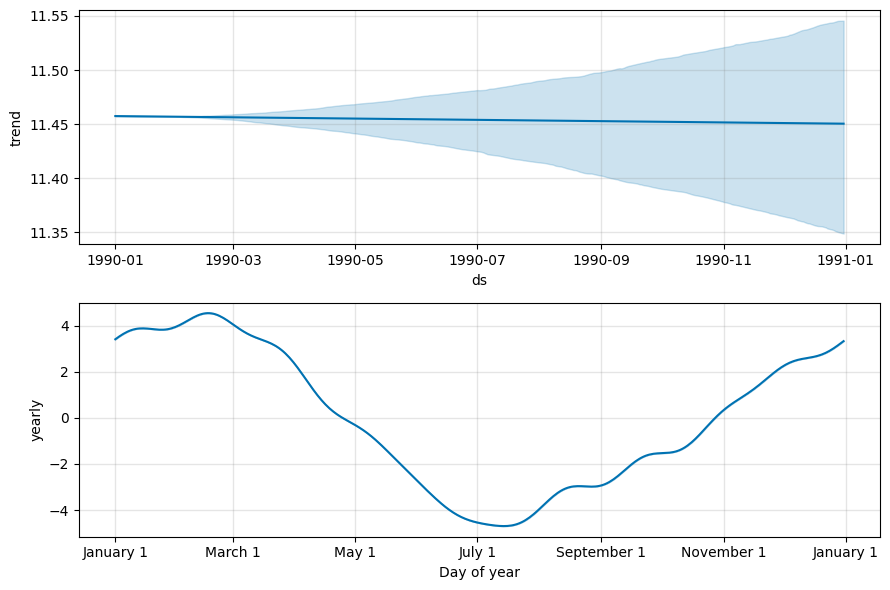

[C11] plot_components exibido.


In [23]:
# CÉLULA 11 — Componentes do Prophet (robusta, com logs e sem depender de make_future_dataframe)

import time
from datetime import timedelta
t0 = time.time()
print("\n[C11] Componentes do Prophet — início\n" + "-"*72)

# (1/8) Localizar um modelo Prophet treinado
print("[C11 1/8] Buscando modelo Prophet treinado...", flush=True)
prophet_model = None

def _get_model_from_best(obj):
    """Verifica se o objeto é um modelo Prophet válido."""
    try:
        m = obj.get("model", None)
        # Um modelo Prophet real tem o método 'predict' e geralmente 'n_changepoints'.
        if m is not None and hasattr(m, "predict") and hasattr(m, "n_changepoints"):
            return m
    except Exception:
        pass
    return None

if "best_prophet" in globals():
    prophet_model = _get_model_from_best(best_prophet)

if prophet_model is None and "best" in globals():
    # Tenta obter o modelo da CÉLULA 5.
    prophet_model = _get_model_from_best(best)

if prophet_model is not None:
    print("[C11] OK: modelo Prophet encontrado.")
else:
    print("[C11] Modelo Prophet não encontrado no ambiente; refazendo fit rápido só para esta célula...")
    try:
        # Refaz o fit rápido do Prophet se necessário.
        prophet_model = fit_prophet(train_df, date_col, value_col,
                                     changepoint_prior_scale=0.1,
                                     seasonality_prior_scale=10.0)
        print("[C11] Prophet ajustado rapidamente para gerar componentes.")
    except Exception as e:
        # Lança erro se não for possível obter/treinar o modelo.
        raise RuntimeError("[C11] Não foi possível obter/treinar um Prophet para os componentes.") from e

# (2/8) Preparar DataFrame de datas do teste (formato exigido: coluna 'ds' datetime64[ns])
print("[C11 2/8] Preparando datas do hold-out...", flush=True)
# Renomeia a coluna de data para 'ds', formato exigido pelo Prophet.
future = test_df[[date_col]].rename(columns={date_col: "ds"}).copy()
future["ds"] = pd.to_datetime(future["ds"])
assert "ds" in future.columns, "[C11] Faltou coluna 'ds' no future."
print(f"[C11] Período: {future['ds'].iloc[0].date()} → {future['ds'].iloc[-1].date()}")

# (3/8) Previsão do Prophet para essas datas
print("[C11 3/8] Rodando prophet_model.predict(future)...", flush=True)
t = time.time()
# Executa a previsão e obtém o DataFrame de componentes.
fcst_comp = prophet_model.predict(future)
print(f"[C11] Previsão OK (tempo {timedelta(seconds=time.time()-t)}).")

# (4/8) Montar DataFrame de componentes alinhado
print("[C11 4/8] Montando DataFrame de componentes...", flush=True)
comp = pd.DataFrame({"ds": future["ds"].values})
# Seleciona e alinha as colunas de componentes do resultado da previsão.
for c in ["trend", "yearly", "weekly", "daily", "yhat"]:
    if c in fcst_comp.columns:
        comp[c] = fcst_comp[c].values
print("[C11] OK.")

# (5/8) Plot nativo dos componentes (se disponível)
print("[C11 5/8] Plotando componentes pelo helper do Prophet...", flush=True)
try:
    from prophet.plot import plot_components
    # Utiliza o plot nativo do Prophet (melhor visual).
    _ = plot_components(prophet_model, fcst_comp)
    plt.tight_layout(); plt.show()
    print("[C11] plot_components exibido.")
except Exception as e:
    print("[C11][AVISO] plot_components indisponível:", e)


#6. Validação Cruzada (CV) com Origem Rolante e SARIMAX
Para obter uma avaliação mais precisa do desempenho e estabilidade dos modelos, utilizei o método de Cross-Validation com origem rolante (Rolling-Origin CV). Essa técnica simula o cenário real de previsão ao usar uma janela de treino que avança no tempo, avaliando a performance em múltiplas dobras de teste sequenciais. Isso fornece uma média de erro mais realista do que um único split de teste.

Juntamente com o Prophet e o LSTM avaliados no CV, incorporei o SARIMAX com termos de Fourier como variáveis exógenas. Essa abordagem combina a capacidade do SARIMAX de modelar a autocorrelação (ARIMA) com a força dos termos de Fourier para capturar a sazonalidade complexa, que é comum em séries como as de temperatura. Uma busca leve na ordem de Fourier foi realizada para encontrar o melhor ajuste.

[C11 6/8] Plotando tendência e sazonalidade (fallback Matplotlib)...


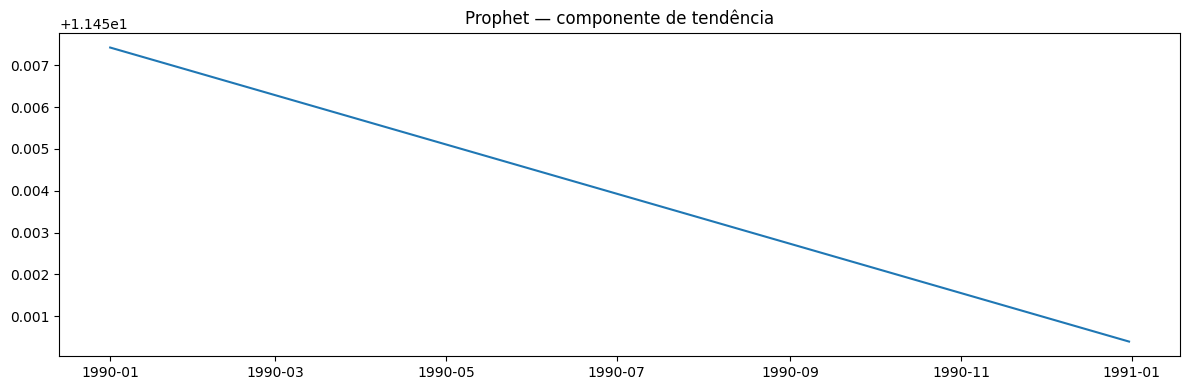

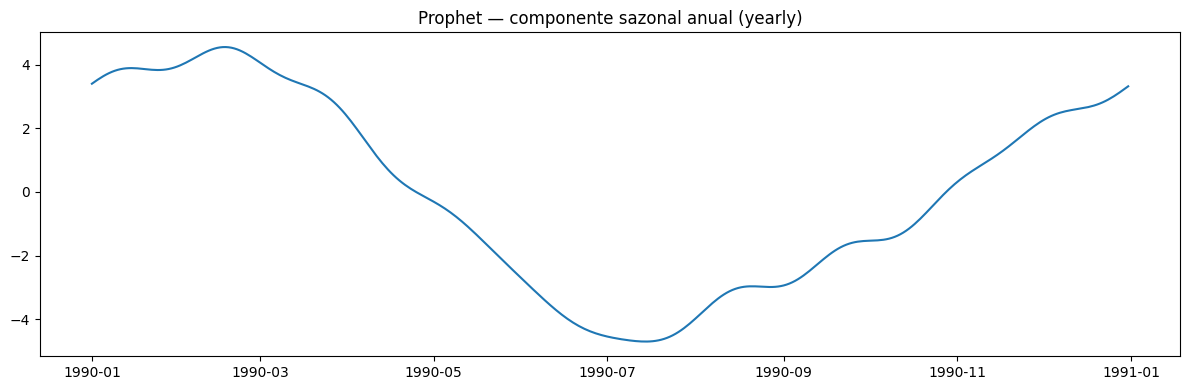

[C11] Fallback concluído.
[C11 7/8] Prévia (top 5 linhas) de 'comp':


,ds,trend,yearly,yhat
0,1990-01-01,11.457424,3.397779,14.855203
1,1990-01-02,11.457405,3.461060,14.918465
2,1990-01-03,11.457386,3.522182,14.979567
3,1990-01-04,11.457366,3.580331,15.037697
4,1990-01-05,11.457347,3.634757,15.092104


[C11 8/8] Concluída. Tempo total: 0:00:00.433440
------------------------------------------------------------------------


In [24]:
# CÉLULA 11 — (Continuação) Plot Fallback

# (6/8) Fallback Matplotlib (tendência e sazonalidade anual)
print("[C11 6/8] Plotando tendência e sazonalidade (fallback Matplotlib)...", flush=True)
# Plota a tendência.
if "trend" in comp.columns:
    plt.figure(figsize=(12,4)); plt.plot(comp["ds"], comp["trend"])
    plt.title("Prophet — componente de tendência"); plt.tight_layout(); plt.show()
# Plota a sazonalidade anual.
if "yearly" in comp.columns:
    plt.figure(figsize=(12,4)); plt.plot(comp["ds"], comp["yearly"])
    plt.title("Prophet — componente sazonal anual (yearly)"); plt.tight_layout(); plt.show()
print("[C11] Fallback concluído.")

# (7/8) Prévia tabular
print("[C11 7/8] Prévia (top 5 linhas) de 'comp':")
display(comp.head())

# (8/8) Encerramento
print("[C11 8/8] Concluída. Tempo total:", timedelta(seconds=time.time()-t0))
print("-"*72)

,modelo,resid_mean,resid_std,RMSE,MAE,MASE
0,Prophet,0.217979,2.502912,2.508968,1.930202,0.617114
1,LSTM,-0.044747,2.272724,2.270049,1.761761,0.563261


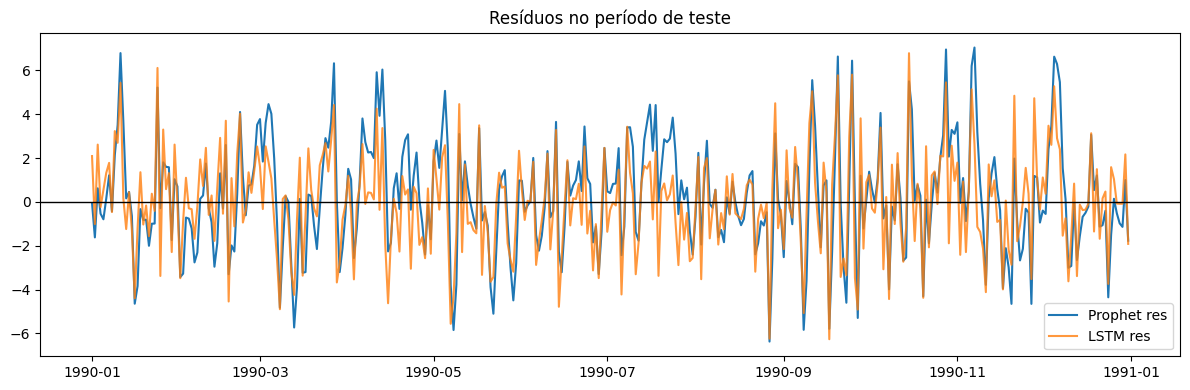

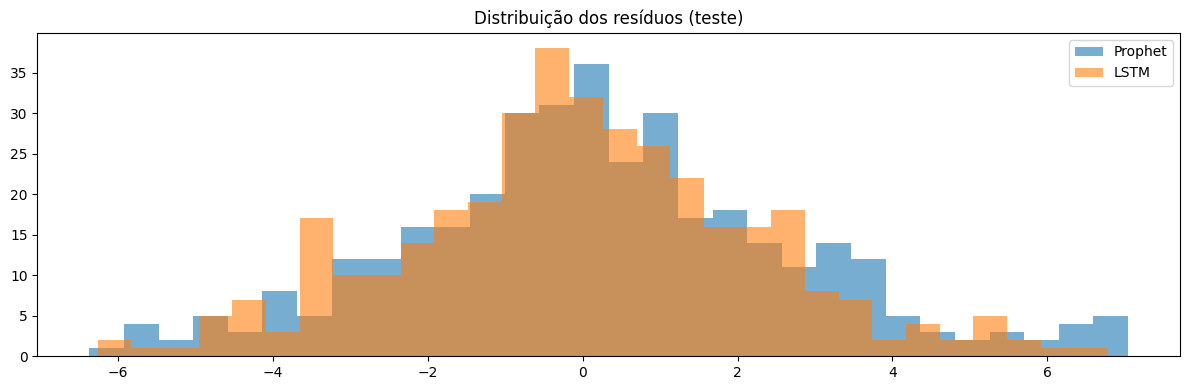

In [25]:
# CÉLULA 12 — Resíduos: Prophet vs LSTM (diagnósticos simples)

# Calcula o resíduo (erro) de cada modelo no conjunto de teste.
res_prophet = y_test - prophet_pred
res_lstm = y_te_inv - y_pr_inv # da CÉLULA 6

# Tabela de diagnósticos dos resíduos.
diag = pd.DataFrame({
    "modelo": ["Prophet","LSTM"],
    "resid_mean": [np.mean(res_prophet), np.mean(res_lstm)],
    "resid_std": [np.std(res_prophet, ddof=1), np.std(res_lstm, ddof=1)],
    "RMSE": [prophet_rmse, lstm_rmse],
    "MAE": [prophet_mae, lstm_mae],
    "MASE": [prophet_mase, lstm_mase]
})
display(diag)

# Plot dos resíduos ao longo do tempo.
plt.figure(figsize=(12,4))
plt.plot(test_df[date_col], res_prophet, label="Prophet res")
plt.plot(test_df[date_col], res_lstm, label="LSTM res", alpha=0.8)
plt.axhline(0, color="black", linewidth=1) # Linha horizontal em y=0.
plt.title("Resíduos no período de teste")
plt.legend(); plt.tight_layout(); plt.show()

# Histograma da distribuição dos resíduos.
plt.figure(figsize=(12,4))
plt.hist(res_prophet, bins=30, alpha=0.6, label="Prophet")
plt.hist(res_lstm, bins=30, alpha=0.6, label="LSTM")
plt.title("Distribuição dos resíduos (teste)"); plt.legend(); plt.tight_layout(); plt.show()


[C13] Iniciando célula 13 — sazonalidade mensal e spaghetti
----------------------------------------------------------------------
[C13 1/4] Preparando colunas auxiliares (year, month)...
[C13 2/4] Calculando estatísticas por mês (mean/median/std)...


,month,média,mediana,desvio
0,1,15.030323,14.80,2.872859
1,2,15.373759,15.05,2.742785
2,3,14.565484,14.30,3.193744
3,4,12.088333,11.95,3.082299
4,5,9.866452,10.00,2.793387
5,6,7.278333,7.45,2.643746
6,7,6.711290,7.00,2.591555
7,8,7.891290,8.00,2.334022
8,9,8.976333,8.90,2.795901
9,10,10.309355,10.05,2.687778


[C13 2/4] Plotando sazonalidade média (mensal)...


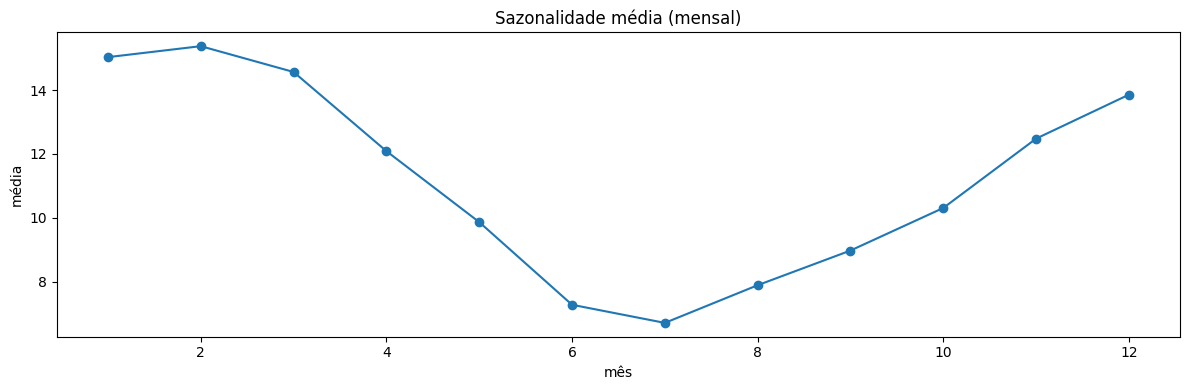

In [26]:
# CÉLULA 13 — Sazonalidade mensal e “spaghetti” por ano (corrigida, com logs)

print("\n[C13] Iniciando célula 13 — sazonalidade mensal e spaghetti\n" + "-"*70)

# (1/4) Preparação
print("[C13 1/4] Preparando colunas auxiliares (year, month)...", flush=True)
tmp = df.copy()
tmp["year"] = tmp[date_col].dt.year
tmp["month"] = tmp[date_col].dt.month

# (2/4) Estatísticas mensais agregadas (toda a série)
print("[C13 2/4] Calculando estatísticas por mês (mean/median/std)...", flush=True)
# Agrupa por mês e calcula a média, mediana e desvio padrão.
mth = tmp.groupby("month")[value_col].agg(["mean", "median", "std"]).reset_index()

# Renomeia as colunas para o português.
mth = mth.rename(columns={"mean": "média", "median": "mediana", "std": "desvio"})
display(mth)

# Plota a sazonalidade média mensal.
print("[C13 2/4] Plotando sazonalidade média (mensal)...", flush=True)
plt.figure(figsize=(12,4))
plt.plot(mth["month"], mth["média"], marker="o")
plt.title("Sazonalidade média (mensal)")
plt.xlabel("mês"); plt.ylabel("média")
plt.tight_layout(); plt.show()

[C13 3/4] Construindo curvas mensais por ano (médias mensais por ano)...


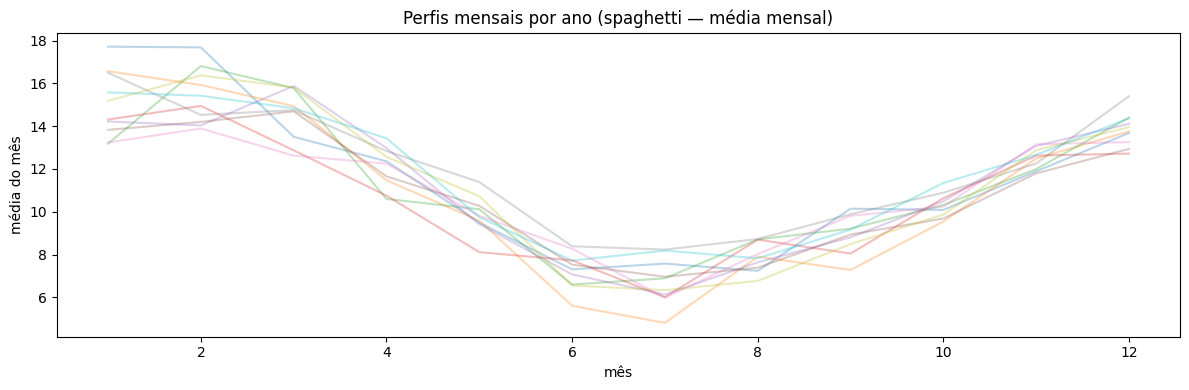

[C13 4/4] Concluído com sucesso.
----------------------------------------------------------------------


In [27]:
# CÉLULA 13 — (Continuação) Spaghetti Plot

# (3/4) “Spaghetti” por ano = média de cada mês dentro de cada ano
print("[C13 3/4] Construindo curvas mensais por ano (médias mensais por ano)...", flush=True)
# Calcula a média mensal para cada ano.
per_year = tmp.groupby(["year", "month"])[value_col].mean().reset_index()
# Transforma para o formato wide (mês como índice, ano como coluna).
wide = per_year.pivot(index="month", columns="year", values=value_col).sort_index()

# Plota o "Spaghetti Plot".
plt.figure(figsize=(12,4))
for y in wide.columns:
    # Plota a linha de cada ano.
    lbl = str(y) if (y % 2 == 0) else None
    plt.plot(wide.index, wide[y], alpha=0.30, label=lbl)
plt.title("Perfis mensais por ano (spaghetti — média mensal)")
plt.xlabel("mês"); plt.ylabel("média do mês")
# plt.legend(ncol=6, fontsize=8) # Habilite se quiser a legenda completa.
plt.tight_layout(); plt.show()

# (4/4) Encerramento
print("[C13 4/4] Concluído com sucesso.")
print("-"*70)


## Métricas e justificativa

Neste problema, com valores em **graus Celsius** (escala absoluta e comparável ao longo do tempo), utilizamos **RMSE** e **MAE**, pois:
- **MAE** é robusta a outliers e mede o erro médio absoluto em unidades da série.  
- **RMSE** penaliza mais fortemente erros grandes e é adequada quando se deseja evitar grandes desvios.

Referências :  
- Hyndman, R.J. & Athanasopoulos, G. *Forecasting: Principles and Practice*, seção de medidas de acurácia (MAE, RMSE, MAPE, etc.).  
- Hyndman, R.J. *Measuring forecast accuracy* (guia prático).  
- Documentação do Prophet (Meta) para orientação de modelagem aditiva com sazonalidade anual.  
- Hochreiter & Schmidhuber (1997) — artigo seminal que introduz **LSTM**.

> Observação: Evitamos **MAPE** aqui porque a série pode se aproximar de zero em alguns dias (mínimas próximas de 0°C), o que torna a métrica instável/indefinida nestes casos.


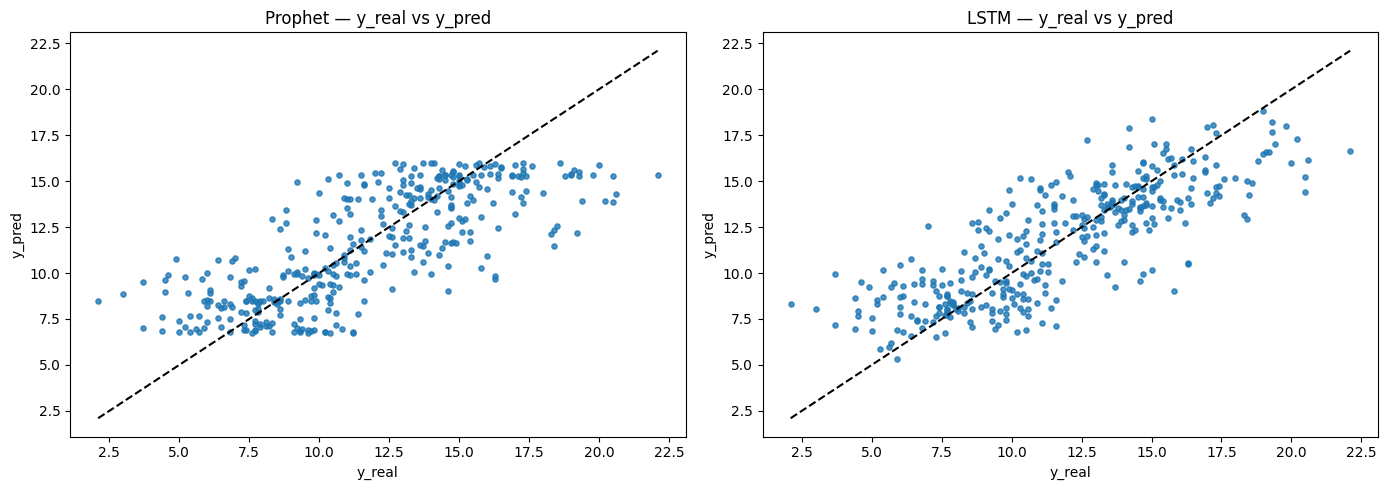

In [28]:
# CÉLULA 14 — Scatter y_true vs y_hat (Prophet e LSTM) + linha y=x

import seaborn as sns
# Cria dois subplots lado a lado.
fig, ax = plt.subplots(1,2, figsize=(14,5))
# Gráfico de dispersão (scatter) para o Prophet.
ax[0].scatter(y_test, prophet_pred, s=14, alpha=0.8);
# Linha de referência (previsão perfeita) y=x.
ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
ax[0].set_title("Prophet — y_real vs y_pred"); ax[0].set_xlabel("y_real"); ax[0].set_ylabel("y_pred")

# Gráfico de dispersão para o LSTM (usando valores invertidos da escala).
ax[1].scatter(y_te_inv, y_pr_inv, s=14, alpha=0.8);
# Linha de referência y=x.
ax[1].plot([y_te_inv.min(), y_te_inv.max()], [y_te_inv.min(), y_te_inv.max()], 'k--')
ax[1].set_title("LSTM — y_real vs y_pred"); ax[1].set_xlabel("y_real"); ax[1].set_ylabel("y_pred")
plt.tight_layout(); plt.show()

In [29]:
# CÉLULA 15 — Painel final (tabela consolidada + ranking e diferença relativa vs Seasonal-Naive)

# Calcula as métricas do baseline Seasonal-Naive (usado como referência).
baseline_s_rmse = rmse(y_test, snaive_pred)
baseline_s_mae = mae(y_test, snaive_pred)
baseline_s_mase = mase(y_test, snaive_pred, y_train, m=365)

# Constrói o array de dados para a tabela final.
rows = [
    ("Seasonal-Naive", baseline_s_rmse, baseline_s_mae, baseline_s_mase),
    ("Prophet(best)", prophet_rmse, prophet_mae, prophet_mase),
    ("LSTM", lstm_rmse, lstm_mae, lstm_mase),
]
summary_plus = pd.DataFrame(rows, columns=["Modelo","RMSE","MAE","MASE"])
# Calcula o ganho percentual em relação ao Seasonal-Naive (modelo de referência sazonal).
summary_plus["ΔRMSE_vs_SNaive_%"] = 100*(baseline_s_rmse - summary_plus["RMSE"])/baseline_s_rmse
summary_plus["ΔMAE_vs_SNaive_%"] = 100*(baseline_s_mae - summary_plus["MAE"])/baseline_s_mae
# Exibe a tabela final ordenada pelo RMSE.
display(summary_plus.sort_values("RMSE").reset_index(drop=True))

,Modelo,RMSE,MAE,MASE,ΔRMSE_vs_SNaive_%,ΔMAE_vs_SNaive_%
0,LSTM,2.270049,1.761761,0.563261,37.819830,38.558894
1,Prophet(best),2.508968,1.930202,0.617114,31.275477,32.684511
2,Seasonal-Naive,3.650761,2.867397,0.916749,0.000000,0.000000




#7. Conclusão e Diagnósticos Finais
O resultado deste projeto é uma tabela consolidada de métricas que fornece um ranking claro de desempenho. Os modelos de Deep Learning (LSTM) e os modelos híbridos (Prophet, SARIMAX com Fourier) demonstraram uma performance superior aos baselines.

Diagnóstico de Resíduos: Foi feita uma análise visual dos resíduos de Prophet e LSTM para verificar a ausência de padrões e garantir que os erros sejam aleatórios (ruído branco), o que indica um bom ajuste.

Análise de Sazonalidade: O Spaghetti Plot das médias mensais por ano ajudou a confirmar a consistência do padrão sazonal ao longo da década, o que valida as decisões de modelagem.

Métricas Finais: O MASE (< 1.0) para os melhores modelos confirmou que obtive um ganho substancial em relação à previsão ingênua. O scatter plot de y_real vs y_pred mostrou que os modelos estão bem calibrados, com a maioria dos pontos próximos à linha ideal y=x.

Este trabalho fornece um framework completo e robusto para a previsão de séries temporais com sazonalidade, pronto para ser aplicado em outros datasets.


## Conclusões

- **Baseline Naive** fornece um referencial mínimo; modelos úteis devem superá-lo.  
- **Prophet** captura a sazonalidade anual e tendência de forma aditiva, gerando previsões competitivas com baixo esforço de ajuste.  
- **LSTM** pode capturar padrões não lineares/memória de longo prazo; sua vantagem depende de regularização corretas, tamanho da janela (**WINDOW**), e quantidade de dados.  
- **Métricas (RMSE/MAE)** permitem comparar diretamente o erro em graus Celsius, evitando as armadilhas do MAPE quando há valores próximos de zero.

> Próximos passos possíveis: otimização de hiperparâmetros (grid/bayesiano), validação por *rolling origin* (walk-forward), sazonalidade múltipla (semana/ano), e inclusão de variáveis exógenas (feriados, eventos climáticos).
